### Introduction

The dataset used for this project was sourced from: https://www.kaggle.com/datasets/xiaomengsun/car-insurance-claim-data

The data includes around 8000 records of car insurance policyholders. This includes features such as their age, income, gender, claim history and more. 

The data include 2 target variables: If a claim has occurred, and the total cost of the claim given a claim has been made.

### Objective

The problem will be projected and will have 2 parts - classification, predicting if a claim has occurred, and regression, predicting the value of a claim assuming a claim has been made. 

In [1]:
!pip install xgboost
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform

### 1. Basic Data Cleaning and Creating Train/Test Split
#### 1.1 Reading in the data and inspection

In [3]:
path_data = r"C:\Users\maste\Dropbox\PC\Downloads\car insurance project\car_insurance_claim (1).csv"
raw_data = pd.read_csv(path_data)

In [4]:
pd.set_option('display.max_columns', None)
raw_data.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


#### 1.2 Basic Data Cleaning
We'll start by creating a copy of the data we've just read in.

In [5]:
# Create new copy of data
data_df = raw_data.copy()

First we will rename the columns to make them more description so they are easier to work with.

In [6]:
# Define updated column names
col_names = {
    'KIDSDRIV': 'num_young_drivers',
    'BIRTH': 'date_of_birth',
    'AGE': 'age',
    'HOMEKIDS': 'num_of_children',
    'YOJ': 'years_job_held_for',
    'INCOME': 'income',
    'PARENT1': 'single_parent',
    'HOME_VAL': 'value_of_home',
    'MSTATUS': 'married',
    'GENDER': 'gender',
    'EDUCATION': 'highest_education',
    'OCCUPATION': 'occupation',
    'TRAVTIME': 'commute_dist',
    'CAR_USE': 'type_of_use',
    'BLUEBOOK': 'vehicle_value',
    'TIF': 'policy_tenure',
    'CAR_TYPE': 'vehicle_type',
    'RED_CAR': 'red_vehicle',
    'OLDCLAIM': '5_year_total_claims_value',
    'CLM_FREQ': '5_year_num_of_claims',
    'REVOKED': 'licence_revoked',
    'MVR_PTS': 'license_points',
    'CLM_AMT': 'new_claim_value',
    'CAR_AGE': 'vehicle_age',
    'CLAIM_FLAG': 'is_claim',
    'URBANICITY': 'address_type'
}

# Update column names
data_df.rename(columns=col_names, inplace=True)

In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10302 non-null  int64  
 1   num_young_drivers          10302 non-null  int64  
 2   date_of_birth              10302 non-null  object 
 3   age                        10295 non-null  float64
 4   num_of_children            10302 non-null  int64  
 5   years_job_held_for         9754 non-null   float64
 6   income                     9732 non-null   object 
 7   single_parent              10302 non-null  object 
 8   value_of_home              9727 non-null   object 
 9   married                    10302 non-null  object 
 10  gender                     10302 non-null  object 
 11  highest_education          10302 non-null  object 
 12  occupation                 9637 non-null   object 
 13  commute_dist               10302 non-null  int

Check for duplicated and null values

In [8]:
# Check number of duplicate records
data_df.duplicated().sum()

1

We have a single duplictae, so let's proceed with dropping it.

In [9]:
# Drop duplicates
data_df.drop_duplicates(inplace=True)

The currency based columns include values with '$' and ','. We need to remove these characters and convert the values to integers.

In [10]:
# Define currency based columns
currency_cols = ['income', 'value_of_home', 'vehicle_value', '5_year_total_claims_value', 'new_claim_value']

# Create function to remove '$' and ','
def format_currency_cols(data, cols):
    for col in cols:
        data[col] = data[col].replace('[\\$,]', '', regex=True).astype('Int64')
    return data

data_df = format_currency_cols(data_df, currency_cols)

Many records across multiple features include a 'z_' prefix. This must be removed.

In [11]:
# Define columns that have prefix
z_prefix_cols = ['married', 'gender', 'highest_education', 'occupation', 'vehicle_type', 'address_type']

# Create function to remove 'z_' prefix
def remove_prefix(data, cols):
    for col in cols:
        data[col] = data[col].replace('[z_]', '', regex=True)
    return data

data_df = remove_prefix(data_df, z_prefix_cols)

At this stage we can drop unuseful features:
* ID is just a unique identifier so is not needed
* data_of_birth duplicates the age feature (as age infers this information) so is not needed

In [12]:
data_df.drop(['ID', 'date_of_birth'], axis=1, inplace=True)

We can now inspect the data after cleaning.

In [13]:
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


#### 1.3 Create Train/Test Split
Since no test set is provided by the authoer, we'll hold out a portion of the data as our test set.

In terms of creating our test set, our best option here would be to use stratified sampling to prevent bias. We can do this by creating bins (strata) based on the 'new_claim_value' amount, as non-zero values here imply 'is_claim' is 1 (true) anyway. We can double check this before doing out stratified sampling:

In [14]:
# Check there are no non-zero values for 'new_claim_value' where 'is_claim' = 1
mask = (data_df['new_claim_value'] > 0) & (data_df['is_claim'] == 0)
data_df[mask]

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type


Good, so we can see when 'new_claim_value' is greater than 0, 'is_claim' is always 1, which is what we would expect.

Let's now see the distribution for claim values to help define the number and width of bins we should use:

<Axes: xlabel='new_claim_value', ylabel='Count'>

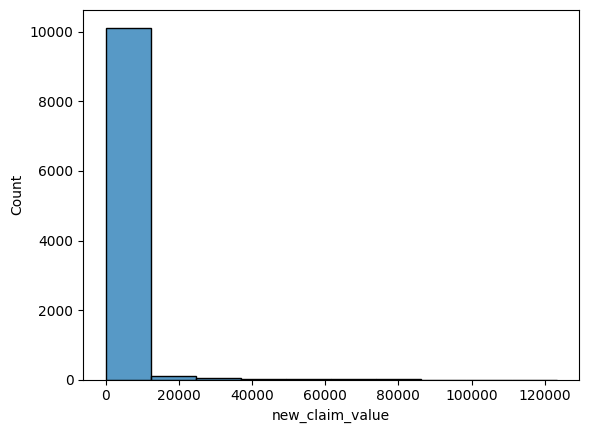

In [15]:
# Create hisogram for new claim value
sns.histplot(data_df['new_claim_value'], bins=10)

We can see the feature is heavily skewed right. It would likely be best to use non-linearly spaced bins to capture the more extreme values with few instances.

In [16]:
# Define bins
bins = [0.0, 5000, 10_000, 15_000, 20_000, 25_000, 30_000, 35_000, 40_000, 45_000, 50_000, np.inf]
# Define bin labels
labels = np.arange(1, 12)

# Apply the bins using cut
data_df['claim_value_cat'] = pd.cut(data_df['new_claim_value'], bins = bins, labels= labels, include_lowest=True)

We can now see the distribution of our new_claim_value categories by creating a barplot.

<Axes: ylabel='claim_value_cat'>

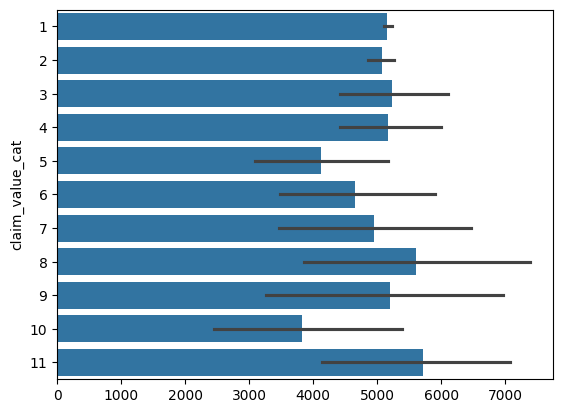

In [17]:
sns.barplot(data_df['claim_value_cat'])

The distribution looks ok for now, so we'll proceed with creating the split.

In [18]:
# Create clean copy of training data
X = data_df.copy()
y = data_df['is_claim']

# Drop the target feature
X.drop(columns=['new_claim_value','is_claim'], inplace=True)

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['claim_value_cat'])

We can quickly compare the distibution of positive/negative class for 'is_claim' in the y_train and y_test classes:

In [19]:
train_ratio = round((y_train.sum()/len(y_train))*100,2)
test_ratio = round((y_test.sum()/len(y_test)*100),2)

print(f'Train positive class ratio: {train_ratio}%')
print(f'Test positive class ratio: {test_ratio}%')

Train positive class ratio: 26.48%
Test positive class ratio: 27.37%


This looks good. We now need to drop the claim_value_cat feature from our X train and test sets:

In [20]:
for set_ in (X_train, X_test):
    set_.drop(columns=['claim_value_cat'], inplace=True)

### 2. Exploratory Data Analysis (EDA)
#### 2.1 Preparation

For the purpose of our EDA, we'll join X_train and y_train so we can investigate correlation.

In [21]:
# Create a new copy of X_train for the analysis
eda_test_data = X_train.copy()
eda_test_data['is_claim'] = y_train

For the purpose of the exploration, we will first update 'Yes/No' features to bonary so we can see how these correlate too. We'll also update gender to use binary values. 1 = male, 0 = female

In [22]:
# Define binary columns
binary_cols = ['single_parent', 'married', 'gender', 'red_vehicle', 'licence_revoked']

# Define map values
mapping = {'Yes': 1,
           'No': 0,
           'yes': 1,
           'no': 0,
           'M': 1,
           'F': 0,
           }

# Define function to binarise features
def binarise_values(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data

# Call function
eda_test_data = binarise_values(eda_test_data, binary_cols, mapping)

In [23]:
# Check updated values
eda_test_data.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,address_type,is_claim
8452,0,57.0,0,NaN,33707,0,0,0,0,<High School,Blue Collar,40,Private,7200,10,SUV,0,0,0,0,1,1.0,Highly Rural/ Rural,0
7822,2,41.0,3,14.0,17321,0,109835,1,0,<High School,Blue Collar,24,Private,6530,4,Sports Car,0,0,0,0,3,1.0,Highly Urban/ Urban,0
1312,0,29.0,2,12.0,54310,1,174139,0,1,<High School,Clerical,39,Private,1500,4,Minivan,0,5419,1,0,5,6.0,Highly Urban/ Urban,1
921,0,46.0,1,13.0,62886,1,202178,0,0,Bachelors,Professional,18,Private,22260,1,Minivan,0,5290,1,0,6,6.0,Highly Urban/ Urban,0
8708,0,39.0,0,8.0,115182,0,312887,1,1,High School,Professional,25,Commercial,5400,1,Pickup,0,0,0,0,1,5.0,Highly Urban/ Urban,0


#### 2.2 Correlation Matrix
As there are many features, we'll create a correlation matrix from just the is_claim target feature.

In [24]:
eda_test_data.corr(numeric_only=True).sort_values(by='is_claim',ascending=False)

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,commute_dist,vehicle_value,policy_tenure,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,is_claim
is_claim,0.109085,-0.107146,0.128697,-0.053815,-0.147085,0.154323,-0.193881,-0.132326,-0.021205,0.044019,-0.103979,-0.082839,-0.007045,0.147094,0.224952,0.158972,0.218605,-0.113344,1.000000
5_year_num_of_claims,0.034724,-0.037820,0.038404,-0.026019,-0.044323,0.060335,-0.092703,-0.070880,0.014060,0.006396,-0.034264,-0.015396,0.027464,0.491048,1.000000,0.054301,0.403083,-0.023960,0.224952
license_points,0.052874,-0.079780,0.071365,-0.040719,-0.065223,0.074748,-0.097057,-0.050486,-0.006218,0.006975,-0.053148,-0.032602,0.004845,0.267866,0.403083,0.054818,1.000000,-0.035502,0.218605
licence_revoked,0.040039,-0.045184,0.051109,-0.009085,-0.031050,0.052374,-0.048395,-0.039376,-0.024676,0.002763,-0.028597,-0.029388,-0.018617,0.422329,0.054301,1.000000,0.054818,-0.027414,0.158972
single_parent,0.204141,-0.314111,0.456293,-0.027043,-0.069598,1.000000,-0.248240,-0.476495,-0.061451,-0.016323,-0.042579,0.009828,-0.039510,0.044080,0.060335,0.052374,0.074748,-0.063892,0.154323
5_year_total_claims_value,0.035981,-0.040818,0.049397,-0.005708,-0.049042,0.044080,-0.067330,-0.043098,-0.009735,-0.017241,-0.030692,-0.012395,0.006578,1.000000,0.491048,0.422329,0.267866,-0.031716,0.147094
num_of_children,0.461488,-0.448207,1.000000,0.079570,-0.158150,0.456293,-0.106974,0.037708,-0.114426,-0.000621,-0.109210,0.012882,-0.072370,0.049397,0.038404,0.051109,0.071365,-0.152561,0.128697
num_young_drivers,1.000000,-0.076813,0.461488,0.038082,-0.046508,0.204141,-0.022470,0.037441,-0.041781,0.012918,-0.026245,-0.004106,-0.045062,0.035981,0.034724,0.040039,0.052874,-0.062621,0.109085
commute_dist,0.012918,0.003201,-0.000621,-0.008878,-0.051479,-0.016323,-0.031111,0.007881,-0.007181,1.000000,-0.024179,-0.002833,0.015903,-0.017241,0.006396,0.002763,0.006975,-0.037156,0.044019
red_vehicle,-0.045062,0.028833,-0.072370,0.054180,0.061301,-0.039510,0.027262,-0.018030,0.664545,0.015903,0.028362,-0.010116,1.000000,0.006578,0.027464,-0.018617,0.004845,0.012896,-0.007045


Use Seaborn to create a single column heatmap plot, sorted by correlation value.

<Axes: >

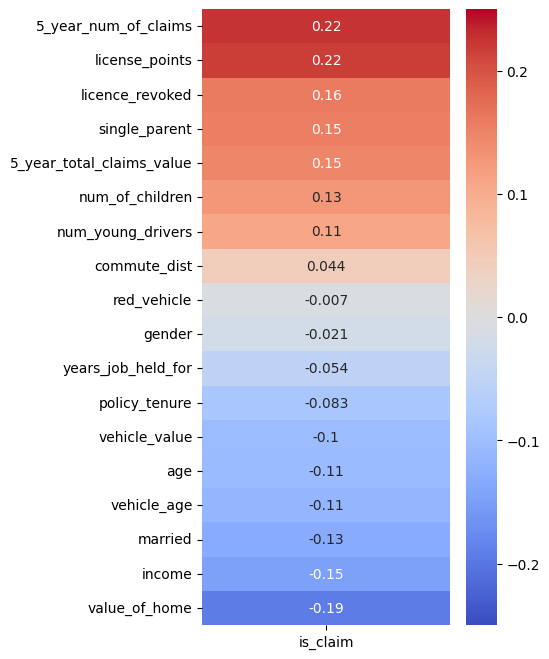

In [25]:
fig, ax = plt.subplots(figsize=(4, 8))

corr_matrix = eda_test_data.corr(numeric_only=True).sort_values(by='is_claim',ascending=False)
corr_matrix_no_claim = corr_matrix.drop('is_claim')

sns.heatmap(corr_matrix_no_claim[['is_claim']],cmap='coolwarm', annot=True, vmax=0.25, vmin=-0.25)

Obervations:

Note, we are not assuming causation, only speculating at possible reasons for correlation.

* Some of the features show much stronger positive correlation than others - these are perhaps the most expected, including:
    * 5_year_num_of_claims: Having made claims previously would suggest they are more likely to make claims in the future
    * license_points: Having points on your license may suggest your driving quality is poor, and make you more likely to be involved in an accident
    * license_revoked: Having your license revoked suggests several minor or a serious driving related offense, perhaps reflecting your driving quality
* Stronger negative correlations:
    * Home value
* Features with negligable correlation:
    * Commute distance, red vehicle and gender show very weak correlations, so it may be beneficial to remove these to reduce the number of features passed to the models

### 3. Data Cleaning and Preprocessing
#### 3.1 Dropping Features
We'll start by dropping the 'red_vehicle' feature, as this showed next to no correlation with the target variable.

In [26]:
X_train_raw = X_train.copy()

cols_to_drop = [
    'red_vehicle',
]

X_train_raw.drop(columns=cols_to_drop, axis=1, inplace=True)

#### 3.2 Handling Missing Values
Let's inspect how many missing values there are in the test data:

In [27]:
# Check the number of missing values in each row
X_train_raw.isnull().sum().sum()

2418

In [28]:
# Check how many missing values there are in each feature
X_train_raw.isnull().sum()

num_young_drivers              0
age                            5
num_of_children                0
years_job_held_for           433
income                       474
single_parent                  0
value_of_home                462
married                        0
gender                         0
highest_education              0
occupation                   527
commute_dist                   0
type_of_use                    0
vehicle_value                  0
policy_tenure                  0
vehicle_type                   0
5_year_total_claims_value      0
5_year_num_of_claims           0
licence_revoked                0
license_points                 0
vehicle_age                  517
address_type                   0
dtype: int64

There is a fairly significant number of missing values. We will need to deal with these when developing the data pipeline. As there are quite a lot of missing values, and many of which are numerical, simple imputation like median or mean may be too naive. Instead, let's impute using KNN for more advanced imputation.

In [29]:
# Create the imputer
knn_imputer = KNNImputer(n_neighbors=2)

# Define the numerical columns
numerical_cols_df = X_train_raw.select_dtypes(include=['number'])
numerical_cols = numerical_cols_df.columns.tolist()

# Define the categorial columns for use later
cat_cols_df = X_train_raw.select_dtypes(include=['object'])
cat_cols = cat_cols_df.columns.tolist()

In [30]:
# Define function to impute num features using KNN
def num_knn_impute(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Run the function to impute numerical values with knn
num_test_data_imputed = num_knn_impute(X_train_raw, numerical_cols, knn_imputer)

We can now check some of the records that had missing data, and the subsequent imputations:

In [31]:
# Get numerical cols as a df
num_cols_df = X_train_raw[numerical_cols].reset_index(drop=True)
# Select rows with missing values and show head
missing_data_df = num_cols_df[num_cols_df.isna().any(axis=1)]
missing_data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
0,0,57.0,0,NaN,33707,0,40,7200,10,0,0,1,1.0
11,0,36.0,2,13.0,19934,<NA>,17,10790,6,7797,2,9,1.0
19,0,59.0,0,11.0,123969,347418,35,31540,1,0,0,1,NaN
25,0,51.0,0,7.0,141546,351285,18,29330,4,1184,2,4,NaN
28,1,51.0,1,8.0,<NA>,253662,5,12430,1,9000,1,0,11.0


In [32]:
# Show same records after imputation
samples = missing_data_df.index.to_list()
num_test_data_imputed.loc[samples].head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0
11,0.0,36.0,2.0,13.0,19934.0,158778.5,17.0,10790.0,6.0,7797.0,2.0,9.0,1.0
19,0.0,59.0,0.0,11.0,123969.0,347418.0,35.0,31540.0,1.0,0.0,0.0,1.0,8.5
25,0.0,51.0,0.0,7.0,141546.0,351285.0,18.0,29330.0,4.0,1184.0,2.0,4.0,7.0
28,1.0,51.0,1.0,8.0,67333.0,253662.0,5.0,12430.0,1.0,9000.0,1.0,0.0,11.0


We can see values have been imputed were we had missing values.

For categorical value imputation, we'll use a simple imputer with 'most_frequent' as the strategy.

In [33]:
# Create the imputer
simple_imputer = SimpleImputer(strategy='most_frequent')

# Define function to impute cat features using simple imputer
def cat_simple_imputer(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Run the function to impute missing categorical values
cat_test_data_imputed = cat_simple_imputer(X_train_raw, cat_cols, simple_imputer)

As before, we can now check before and after imputation for some rows with missing values:

In [34]:
# Get numerical cols as a df
cat_cols_df = X_train_raw[cat_cols].reset_index(drop=True)
# Select rows with missing values and show head
missing_cat_data_df = cat_cols_df[num_cols_df.isna().any(axis=1)]
missing_cat_data_df.head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,No,No,F,<High School,Blue Collar,Private,SUV,No,Highly Rural/ Rural
11,Yes,No,M,High School,Clerical,Private,Pickup,No,Highly Urban/ Urban
19,No,Yes,M,Masters,NaN,Commercial,Panel Truck,No,Highly Urban/ Urban
25,No,No,M,PhD,Manager,Commercial,Panel Truck,No,Highly Urban/ Urban
28,No,Yes,M,High School,Blue Collar,Commercial,Minivan,No,Highly Urban/ Urban


In [35]:
# Show same records after imputation
samples = missing_cat_data_df.index.to_list()
cat_test_data_imputed.loc[samples].head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,No,No,F,<High School,Blue Collar,Private,SUV,No,Highly Rural/ Rural
11,Yes,No,M,High School,Clerical,Private,Pickup,No,Highly Urban/ Urban
19,No,Yes,M,Masters,Blue Collar,Commercial,Panel Truck,No,Highly Urban/ Urban
25,No,No,M,PhD,Manager,Commercial,Panel Truck,No,Highly Urban/ Urban
28,No,Yes,M,High School,Blue Collar,Commercial,Minivan,No,Highly Urban/ Urban


We can now join the numerical and categorical data following imputation, to create the complete DataFrame.

In [36]:
# Rejoin dfs
train_imputed_df = pd.concat([num_test_data_imputed, cat_test_data_imputed], axis=1)
# Check head
train_imputed_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0,No,No,F,<High School,Blue Collar,Private,SUV,No,Highly Rural/ Rural
1,2.0,41.0,3.0,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,0.0,3.0,1.0,No,Yes,F,<High School,Blue Collar,Private,Sports Car,No,Highly Urban/ Urban
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0,Yes,No,M,<High School,Clerical,Private,Minivan,No,Highly Urban/ Urban
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0,Yes,No,F,Bachelors,Professional,Private,Minivan,No,Highly Urban/ Urban
4,0.0,39.0,0.0,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,0.0,1.0,5.0,No,Yes,M,High School,Professional,Commercial,Pickup,No,Highly Urban/ Urban


We can now check again for missing values:

In [37]:
train_imputed_df.isnull().sum()

num_young_drivers            0
age                          0
num_of_children              0
years_job_held_for           0
income                       0
value_of_home                0
commute_dist                 0
vehicle_value                0
policy_tenure                0
5_year_total_claims_value    0
5_year_num_of_claims         0
license_points               0
vehicle_age                  0
single_parent                0
married                      0
gender                       0
highest_education            0
occupation                   0
type_of_use                  0
vehicle_type                 0
licence_revoked              0
address_type                 0
dtype: int64

We can see we now have no missing values in any of the features.

#### 3.4. Categorical Feature Encoding
We now need to consider how we will encode the categorical features so that they can be used with machine learning algorithms. Let's start by looking at the number of unqiue values each categorical feature has, so we can decide the best encoding method for each.

In [38]:
cat_test_data_imputed.nunique()

single_parent        2
married              2
gender               2
highest_education    5
occupation           8
type_of_use          2
vehicle_type         6
licence_revoked      2
address_type         2
dtype: int64

* Single parent has only 2 values, so we can use binary encoding for this feature.
* Married has only 2 values, so we can use binary encoding for this feature.
* Gender has only 2 values, so we can use binary encoding for this feature.
* Highest education has 5 unique values, and these have a rank/order (the level of education). We can use ordinal encoding for this feature.
* For occupation, we have 8 differnet values with no ranking or order. We can use one-hot encoding for this feature.
* Type of use has only 2 values, so we can use binary encoding for this feature.
* Vehicle type has 6 different values with no ranking or order. We can use one-hot encoding for this feature.
* Red vehicle has only 2 values, so we can use binary encoding for this feature.
* License revoked has only 2 values, so we can use binary encoding for this feature.
* Address type has only 2 values, so again, we can use binary encoding for this feature.

Since Scikit-Learn has no binary encoding option currently for independent features, we can use the ordinal encoder in this as we only have 2 unique values. We can now define which features will use which encoders:

In [39]:
# Define ordinal features
cat_cols_ord = ['highest_education']
# Define binary features
cat_cols_bin = ['single_parent', 'married', 'gender', 'type_of_use', 'licence_revoked', 'address_type']
# Define one-hot features
cat_cols_one_hot = ['occupation', 'vehicle_type']

We can now create the encoders for each feature type. For the education encoder we will first need to define the order/ranking of the levels of education.

In [40]:
education_rank = [['<High School', 'High School', 'Bachelors', 'Masters', 'PhD']]

# Define ordinal encoder
ord_encoder = OrdinalEncoder(categories=education_rank)

# Define binary encoder
bin_encoder = OrdinalEncoder()

# Define one-host encoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

We can now encode the values use fit_transform:

In [41]:
# Encode ordinals
ord_encoded = ord_encoder.fit_transform(cat_test_data_imputed[cat_cols_ord])

# Encode binaries
bin_encoded = bin_encoder.fit_transform(cat_test_data_imputed[cat_cols_bin])

# One-hot encoding
one_hot_encoded = one_hot_encoder.fit_transform(cat_test_data_imputed[cat_cols_one_hot])

We can now return these values to a DataFrame to check the encoding:

In [42]:
# Create dfs for each array
ord_encoded_df = pd.DataFrame(ord_encoded)
ord_encoded_df.columns = cat_cols_ord

bin_encoded_df = pd.DataFrame(bin_encoded)
bin_encoded_df.columns = cat_cols_bin

one_hot_encoded_df = pd.DataFrame(one_hot_encoded)
one_hot_encoded_df.columns = one_hot_encoder.get_feature_names_out()

# Join encoded dfs to a single df and show head
all_cat_encoded_df = pd.concat([ord_encoded_df, bin_encoded_df, one_hot_encoded_df], axis=1)
all_cat_encoded_df.head()

,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


We can now join our encoded features back with the numerical features to give us our pre-processed data.

In [43]:
# Join numerical and categorical data
X_train_cleaned = pd.concat([train_imputed_df[numerical_cols], all_cat_encoded_df], axis=1)

In [44]:
# Check df
X_train_cleaned.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2.0,41.0,3.0,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,39.0,0.0,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,0.0,1.0,5.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Since we've used one-hot encoding for some of the features, we will almost certainly have issues with the 'dummy variable trap'. This occurs when one of the dummy variables is redudant, and introduces perfect multicollinearity. In simple terms, knowing the values of all feature values - 1 allows you to perfectly predict the last one. We can check the presence of multicolinearity using the variance inflation factor, or VIF:

In [45]:
# Function to calculate VIF
def calculate_vif(dataframe):
    # Add a constant to the DataFrame (intercept term)
    df_with_constant = add_constant(dataframe)

    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_with_constant.columns
    vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i)
                       for i in range(df_with_constant.shape[1])]

    return vif_data

# Calculate VIF for encoded data
vif_df = calculate_vif(X_train_cleaned)
vif_df

c:\Users\maste\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\maste\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,const,0.000000
1,num_young_drivers,1.317458
2,age,1.470704
3,num_of_children,2.083100
4,years_job_held_for,1.437881
5,income,2.633292
6,value_of_home,2.120414
7,commute_dist,1.039162
8,vehicle_value,2.030342
9,policy_tenure,1.005861


We can clearly see the features that were one-hot encoded (occupation and vehicle type) show perfect multicolinearity. The easiest way to deal with this is to drop one of the dummy variables from the encoded data. This is often referred to as dropping the 'reference category' or 'baseline' category.

In [46]:
X_train_cleaned.drop(['occupation_Blue Collar' ,'vehicle_type_Minivan'], axis=1, inplace=True)

We can now check VIF values again:

In [47]:
# Calculate VIF for encoded data
vif_df = calculate_vif(X_train_cleaned)
vif_df

,Feature,VIF
0,const,80.124998
1,num_young_drivers,1.317458
2,age,1.470704
3,num_of_children,2.083100
4,years_job_held_for,1.437881
5,income,2.633292
6,value_of_home,2.120414
7,commute_dist,1.039162
8,vehicle_value,2.030342
9,policy_tenure,1.005861


### 5. Model Selection - Classfication
We'll start by using several of the most popular classifiers with default parameters and compare how well they perform to indentify which might be best to proceed with.

In [48]:
# Define the classifiers to test
clfs = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', max_iter=8000)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Linear SVM', LinearSVC(random_state=42, max_iter=1000)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42, algorithm='SAMME')),
    ('Gradient Boost', GradientBoostingClassifier(random_state=42)),
    ('Bagging', BaggingClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),
]

We'll use cross-validation to get a better understanding of each models performance, rather than just a single test. Let's create a KFold object so we can use the same folds for each classifier.

In [49]:
# Create KFold object with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dictionary to store results
results = {}

# Evaluate each classifier using cross-validation
for clf_name, clf in clfs:
    cv_scores = cross_val_score(clf, X_train_cleaned, y_train, cv=kf, error_score = 'raise')
    results[clf_name] = cv_scores

cv_scores_df = pd.DataFrame(results)

Let's now plot the results of each test, for each classifyer with a boxplot so we can compare the models.

Text(0.5, 1.0, 'Cross-Validation Scores for Different Classifiers')

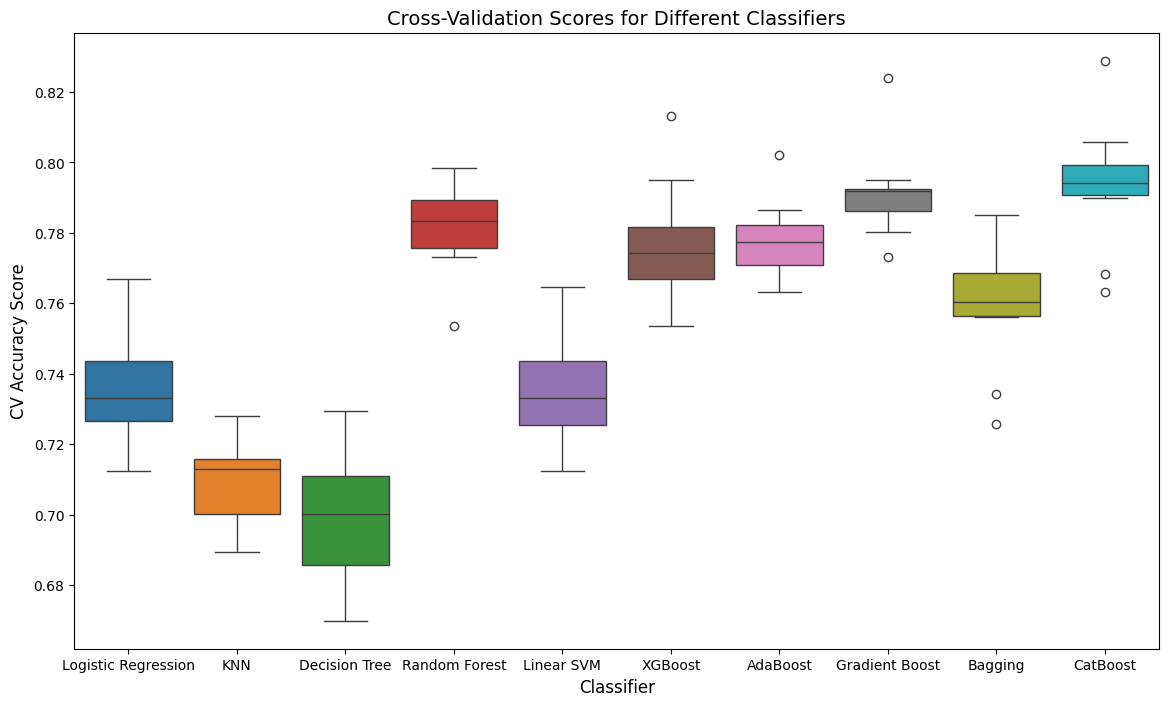

In [50]:
# Plot scores
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(cv_scores_df)

# Add axis labels
ax.set_xlabel('Classifier', fontsize=12)
ax.set_ylabel('CV Accuracy Score', fontsize=12)
ax.set_title('Cross-Validation Scores for Different Classifiers', fontsize=14)

From the table, we can see the best performing model was CatBoost, followed by Gradient Boost. The worst performing model was the Descision Tree.

Although the CatBoost and Gradient Boost models performed better, I'll proceed for now with the XGBoost model, as hyperparameter tuning is much faster.

### 6. Feature Engineering
Let's take a look at the distributions of our numerical features to see if we could potentially improve the performance of our models by transforming any existing features. First we'll create histograms for each of the numerical features.

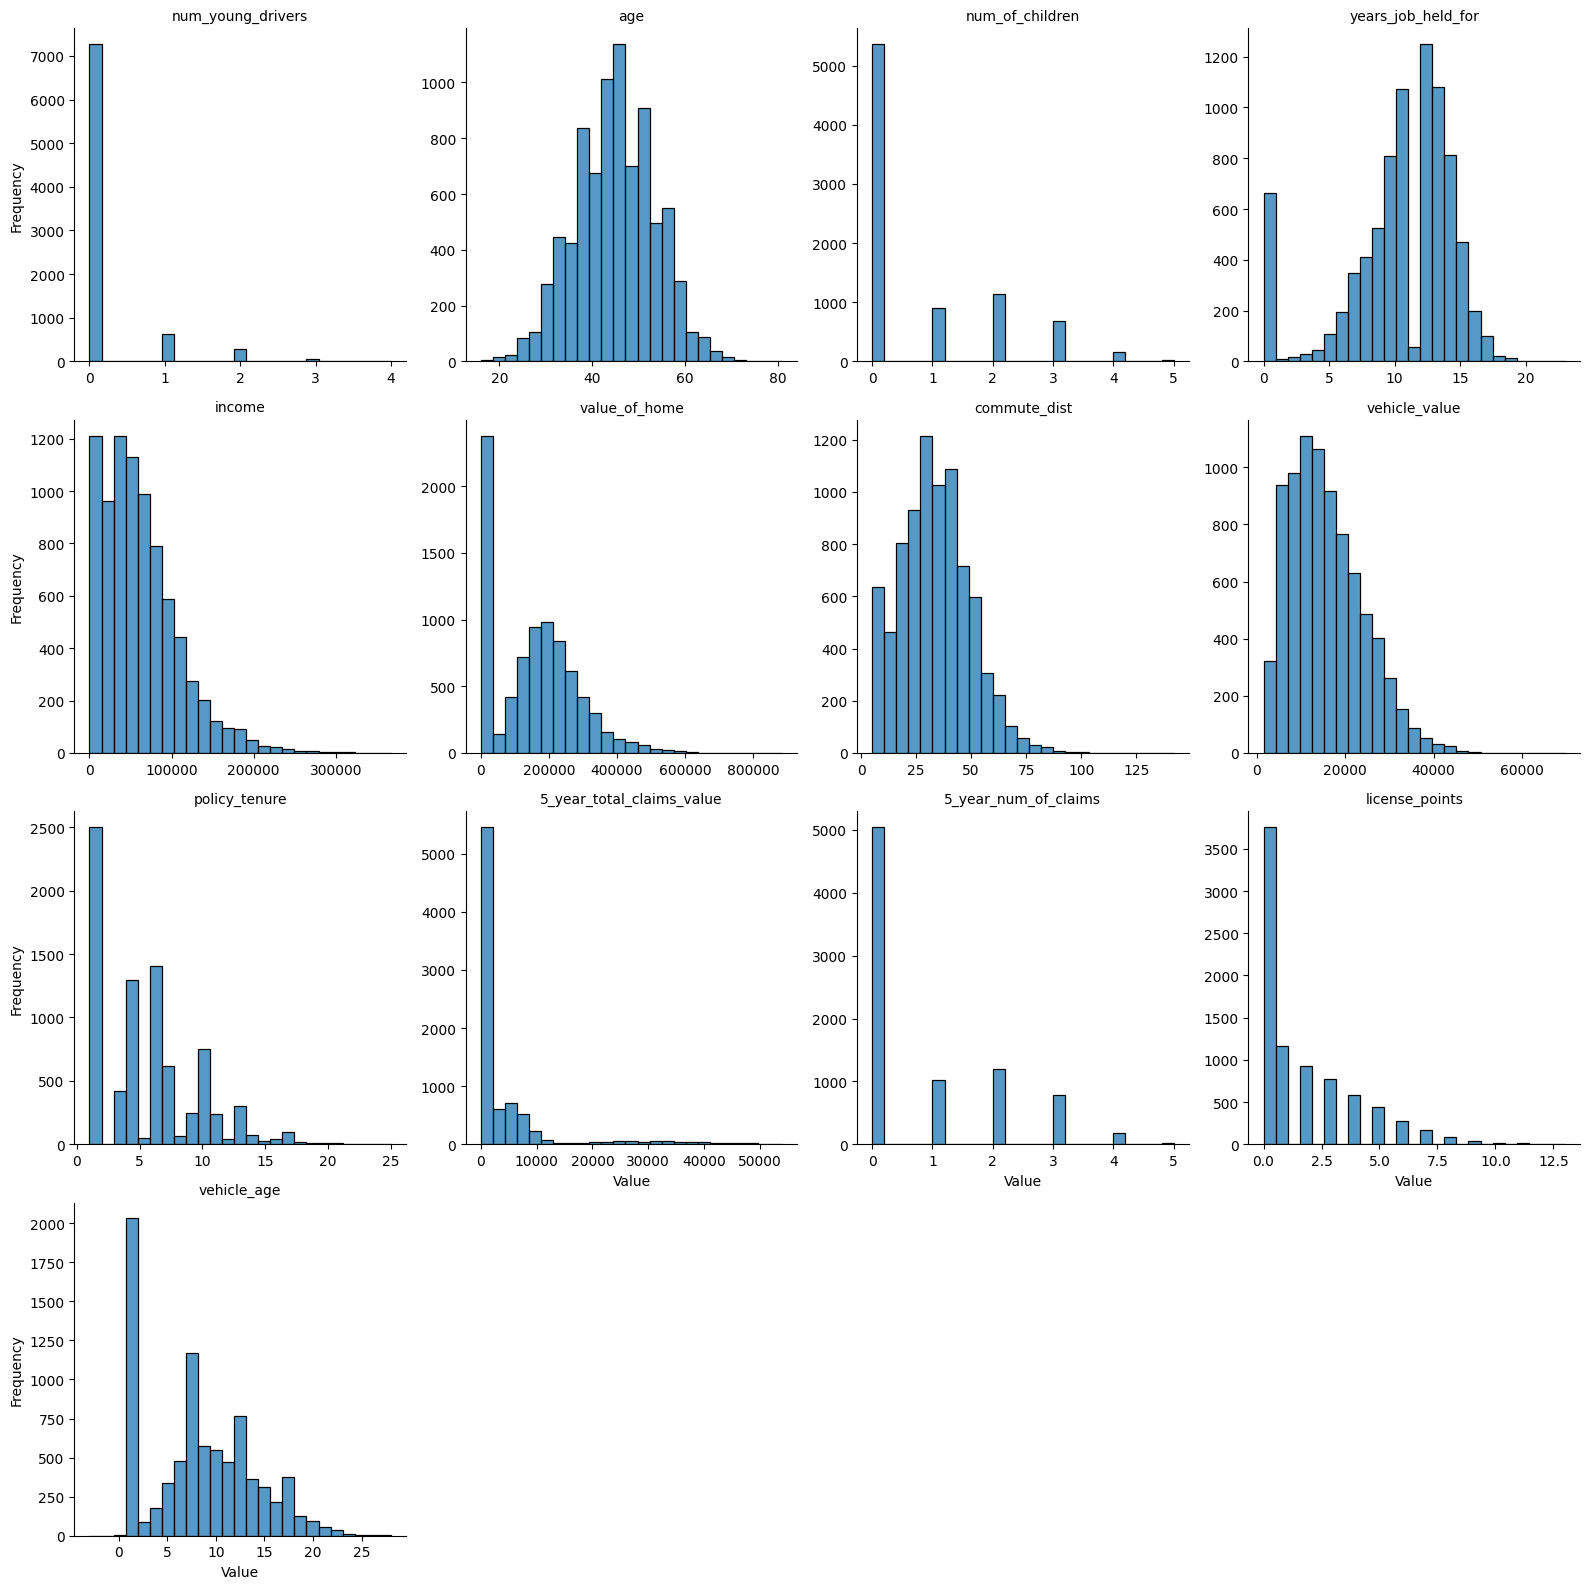

In [51]:
# Melt the DataFrame to long format
melted_X_train = X_train_cleaned[numerical_cols].melt(var_name='Column', value_name='Value')

# Create a FacetGrid
g = sns.FacetGrid(melted_X_train, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)

# Map the sns.histplot to each facet
g.map(sns.histplot, 'Value', bins=25)

# Add titles and labels
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')

plt.tight_layout()
plt.show()

We can see that some of the features have a right skew. We can try to log transform these features to reduce the skew.

In [52]:
# Define features we right skew
skewed_features = ['income', 'value_of_home', 'commute_dist', 'vehicle_value', 'policy_tenure', 'license_points']

# Define function to apply log transform
def log_of_feature(data_df, skewed_features):
    data = data_df.copy()
    for feature in skewed_features:
        data[feature] = np.sqrt(data[feature])
    return data

# Apply the function to X_train
X_train_cleaned_log = log_of_feature(X_train_cleaned, skewed_features)

We can now look at the distributions again to see if the log transform was effective at reducing the right skews.

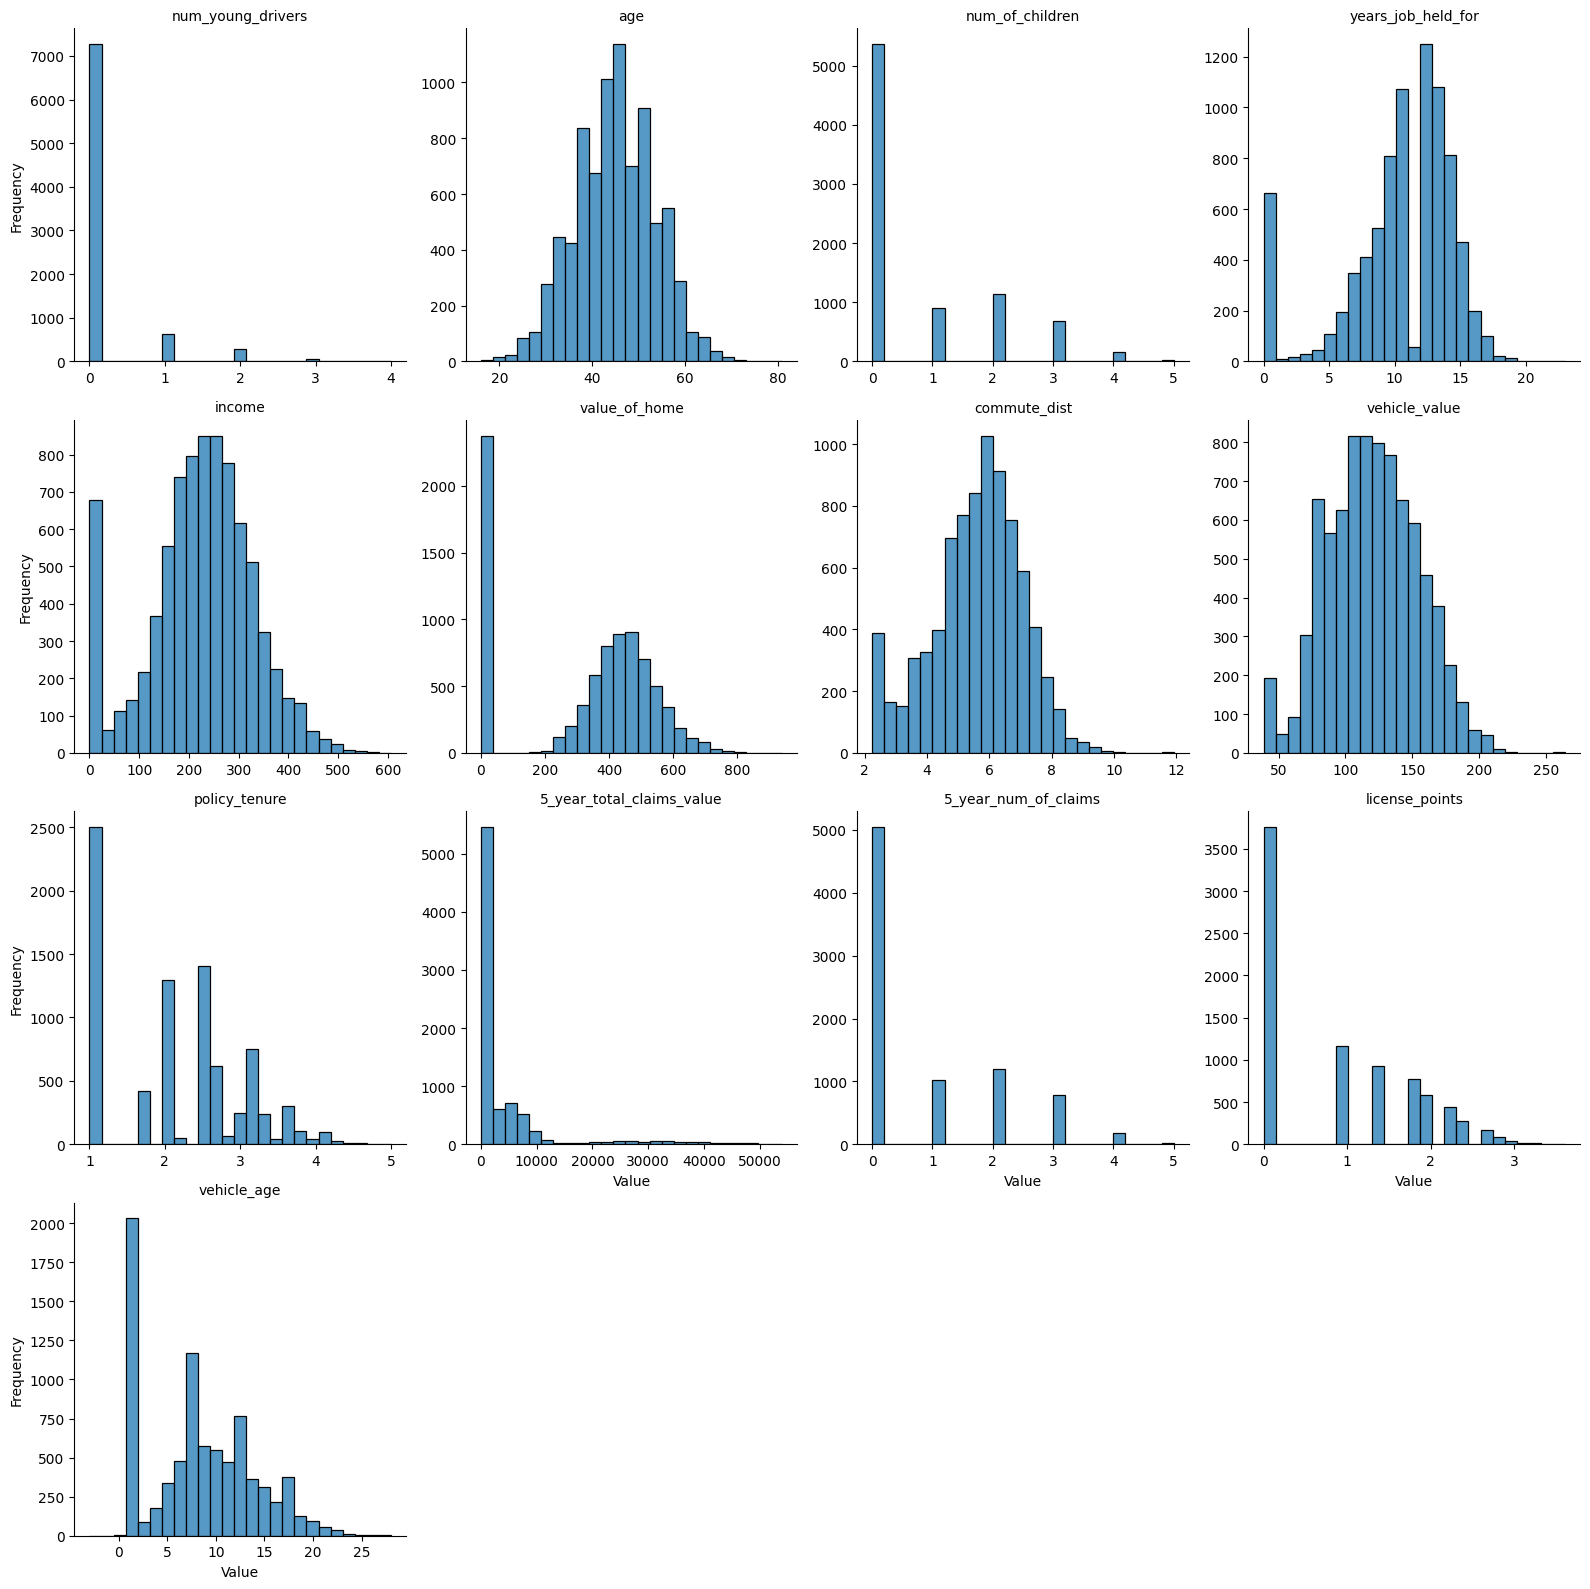

In [53]:
melted_X_train = X_train_cleaned_log[numerical_cols].melt(var_name='Column', value_name='Value')
g = sns.FacetGrid(melted_X_train, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)
g.map(sns.histplot, 'Value', bins=25)
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')
plt.tight_layout()
plt.show()

The skews have been reduced, so let's now see if it has improved the performance of the XGBoost model.

In [54]:
xgb_boost_clf = XGBClassifier(random_state=42)

cv_scores = cross_val_score(xgb_boost_clf, X_train_cleaned, y_train, cv=kf)
cv_scores_log = cross_val_score(xgb_boost_clf, X_train_cleaned_log, y_train, cv=kf)

print(f'CV score without log transform: {cv_scores.mean()}')
print(f'CV score with log transform: {cv_scores_log.mean()}')

CV score without log transform: 0.7770631067961167
CV score with log transform: 0.7770631067961167


It's clear that our log transform made no impact in improving the base score. This is often to be expected with boosting models, as they are less sensitive to skew and scale than some models. However, it may be beneficial to our regression model later so we'll keep it.

#### Feature Scaling

Now let's check if scaling our numerical features has any impact on model performance.

In [55]:
# Define function to scale numeric features
def scale_features(data_df, numeric_features):
    data = data_df.copy()
    # Initialise scaler
    scaler = StandardScaler()
    # Fit scaler to training data
    scaler.fit(data[numeric_features])
    # Transform numeric features
    data[numeric_features] = scaler.transform(data[numeric_features])
    return data

# Apply the function to X_train
X_train_cleaned_scaled = scale_features(X_train_cleaned_log, numerical_cols)

In [56]:
xgb_boost_clf = XGBClassifier(random_state=42)

cv_scores = cross_val_score(xgb_boost_clf, X_train_cleaned, y_train, cv=kf)
cv_scores_scaled = cross_val_score(xgb_boost_clf, X_train_cleaned_scaled, y_train, cv=kf)

print(f'CV score without log transform: {cv_scores.mean()}')
print(f'CV score with log transform: {cv_scores_scaled.mean()}')

CV score without log transform: 0.7770631067961167
CV score with log transform: 0.7770631067961167


Again, it's clear that the scaling made no impact in improving the base score. However, it may be beneficial to our regression model later so we'll keep it.

In [57]:
X_train_cleaned = X_train_cleaned_scaled.copy()

### 7. Model Pipeline
#### 7.1. Custom Transformers
As we want to drop the unwanted 'red_vehicle' column, we'll create a custom transformer to do this that we can use in our pipeline.

In [58]:
# Custom transformer to drop specified columns
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)
    
    def get_feature_names_out(self, input_features=None):
        return None

In [59]:
class SqrtTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.columns_to_transform] = np.sqrt(X[self.columns_to_transform])
        return X

    def get_feature_names_out(self, input_features=None):
        return input_features

#### 7.2. Pipelines
We can now define the pipelines for each of data/encoding types.

In [60]:
from sklearn import set_config

# Set transformer output to df so we can reference columns names
set_config(transform_output='pandas')

In [61]:
# Define column dropper pipeline
cols_to_drop_pipeline = Pipeline([
    ('col_dropper', ColumnDropper(cols_to_drop))
])

skewed_features = ['income', 'value_of_home', 'commute_dist', 'vehicle_value', 'policy_tenure', 'license_points']

# Define numerical feature pipeline
num_pipeline = Pipeline([
    ('knn_imputer', KNNImputer(n_neighbors=2)),
    ('sqrt', SqrtTransformer(skewed_features)),
    ('scaler', StandardScaler()),
])

# Define rank of education levels
education_rank = [['<High School', 'High School', 'Bachelors', 'Masters', 'PhD']]

# Define ordinal categorical feature pipeline (highest_education feature)
cat_ord_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('ord_encoder', OrdinalEncoder(categories=education_rank)),
])

# Define binary categorical feature pipeline
cat_bin_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('binary_encoder', OrdinalEncoder()),
])

# Define one-hot categorical feature pipeline
cat_one_hot_pipeline = Pipeline([
    ('cat_simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')),
])

# Define preprocessing pipeline with a column transformer
preprocess_pipeline = ColumnTransformer([
    ('drop_features', cols_to_drop_pipeline, cols_to_drop),
    ('num', num_pipeline, numerical_cols),
    ('cat_ord', cat_ord_pipeline, cat_cols_ord),
    ('cat_bin', cat_bin_pipeline, cat_cols_bin),
    ('cat_one_hot', cat_one_hot_pipeline, cat_cols_one_hot),
])

We can now transform the raw X_train dataset. With the pipeline.

In [62]:
X_train_prepared = preprocess_pipeline.fit_transform(X_train)

We've transformed the test data using our pipeline. We can check the pipeline is correct by checking it against the DataFrame we built manually. We just need to make sure the column names match so we can compare them.

In [63]:
# Create df from processed data
X_train_prepared_df = pd.DataFrame(
    X_train_prepared,
    columns=preprocess_pipeline.get_feature_names_out(),
)

# Get names of new one-hot columns
one_hot_col_names = list(preprocess_pipeline.transformers_[4][1][1].get_feature_names_out(cat_cols_one_hot))

# Create list of all columns names
new_col_names = numerical_cols + cat_cols_ord + cat_cols_bin + one_hot_col_names

# Rename df columns
X_train_prepared_df.columns = new_col_names

# Reset index
X_train_prepared_df.reset_index(drop=True, inplace=True)

# Inspect df
X_train_prepared_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,-0.332668,1.409817,-0.643344,-2.563674,-0.375723,-1.452458,0.498062,-1.040804,1.139483,-0.461230,-0.691403,0.092242,-1.295667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3.669060,-0.453096,2.054902,0.874127,-0.866152,0.037836,-0.479232,-1.159364,-0.142286,-0.461230,-0.691403,0.878344,-1.295667,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.332668,-1.850281,1.155487,0.383013,0.090791,0.424047,0.443522,-2.392885,-0.142286,0.161972,0.177994,1.419574,-0.405338,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.332668,0.129064,0.256071,0.628570,0.258015,0.569484,-0.929180,0.845452,-1.245093,0.147137,0.177994,1.648754,-0.405338,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.332668,-0.685960,-0.643344,-0.599216,1.093996,1.062875,-0.409978,-1.374057,-1.245093,-0.461230,-0.691403,0.092242,-0.583403,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [64]:
# Inspect manually created df
X_train_cleaned.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,-0.332668,1.409817,-0.643344,-2.563674,-0.375723,-1.452458,0.498062,-1.040804,1.139483,-0.461230,-0.691403,0.092242,-1.295667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3.669060,-0.453096,2.054902,0.874127,-0.866152,0.037836,-0.479232,-1.159364,-0.142286,-0.461230,-0.691403,0.878344,-1.295667,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.332668,-1.850281,1.155487,0.383013,0.090791,0.424047,0.443522,-2.392885,-0.142286,0.161972,0.177994,1.419574,-0.405338,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.332668,0.129064,0.256071,0.628570,0.258015,0.569484,-0.929180,0.845452,-1.245093,0.147137,0.177994,1.648754,-0.405338,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.332668,-0.685960,-0.643344,-0.599216,1.093996,1.062875,-0.409978,-1.374057,-1.245093,-0.461230,-0.691403,0.092242,-0.583403,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [65]:
X_train_cleaned.equals(X_train_prepared_df)

True

Great! We can see the output from the pipeline is the same as our manually created DataFrame.

### 8. Hyperparamter Optimisation
#### 8.1. Random Search
To cover a larger parameter space, we'll first use RandomisedSearchCV with random values from a defined range. We can then focus in on a smaller range of values with GridSearchCV

In [66]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': randint(low=50, high=300),
    'learning_rate':uniform(0.01, 0.29),
    'max_depth': randint(low=1, high = 20),
    'subsample': uniform(0, 1),
    'colsample_bytree': uniform(0, 1),
    'min_child_weight': randint(low=1, high= 20),
    'reg_alpha': randint(low=0, high=100),
    'reg_lambda':randint(low=0, high=10),
    'gamma': uniform(0, 1),
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42, eval_metric='error')

# Set up RandomizedSearchCV with F1 score as the evaluation metric
scorer = make_scorer(f1_score, average='weighted')
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=2000,  # Increased number of iterations
    scoring=scorer,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [67]:
# Fit the model using RandomizedSearchCV
random_search.fit(X_train_prepared, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Best parameters found:  {'colsample_bytree': 0.9503797514820932, 'gamma': 0.9583276864813868, 'learning_rate': 0.03833510986215996, 'max_depth': 15, 'min_child_weight': 14, 'n_estimators': 294, 'reg_alpha': 0, 'reg_lambda': 8, 'subsample': 0.9860674802096018}
Best cross-validation score:  0.7848887763975866


#### 8.2. Grid Search
OK, we now have the best parameter values from our Random Search. As we've reduce the parameter space, we can now use grid search to check parameter combinations within the reduced grid space.

In [70]:
# Define the parameter grid with expanded ranges
xgb_param_grid_grid_search = {
    'n_estimators': [280, 290, 300],
    'max_depth': [6, 7, 8],
    'learning_rate': [0.03, 0.04, 0.05],
    'subsample': [0.45, 0.5, 0.55],
    'colsample_bytree': [0.5, 0.55, 0.6],
    'gamma': [0.05, 0.1, 0.15],
    'min_child_weight': [18],
    'reg_alpha': [1],
    'reg_lambda': [1],
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42, eval_metric='error')

# Set up RandomizedSearchCV with F1 score as the evaluation metric
scorer = make_scorer(f1_score, average='weighted')
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid_grid_search,
    scoring=scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [71]:
# Fit the model using RandomizedSearchCV
grid_search.fit(X_train_prepared, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found:  {'colsample_bytree': 0.5, 'gamma': 0.05, 'learning_rate': 0.04, 'max_depth': 8, 'min_child_weight': 18, 'n_estimators': 280, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.45}
Best cross-validation score:  0.7854672457128494


We've now got the result from the grid search. Let's compared the model scores for the default model, and the tuned model:

In [72]:
print(f'XGBoost model score (default hyperparameters): {cv_scores.mean()}')
print(f'XGBoost model score (tuned hyperparamters: {grid_search.best_score_}')

XGBoost model score (default hyperparameters): 0.7770631067961167
XGBoost model score (tuned hyperparamters: 0.7854672457128494


Great, we saw an improvement of nearly 0.8%.

### 9. Model Evaluation
It's now time to test the model with our test set. 

In [73]:
# Prepare test set using pipeline
X_test_prepared = preprocess_pipeline.fit_transform(X_test)

# Predict the y_test values using the best model from the grid search
y_pred = grid_search.best_estimator_.predict(X_test_prepared)

We can now check the f1 score of our test set predictions:

In [74]:
f1_score(y_test, y_pred, average='weighted')

0.7659841525866742

Let's create a confusion matrix for our model with the results of the test set to better understand it's performance.

Text(0.5, 1.0, 'Confusion Matrix on Training Data')

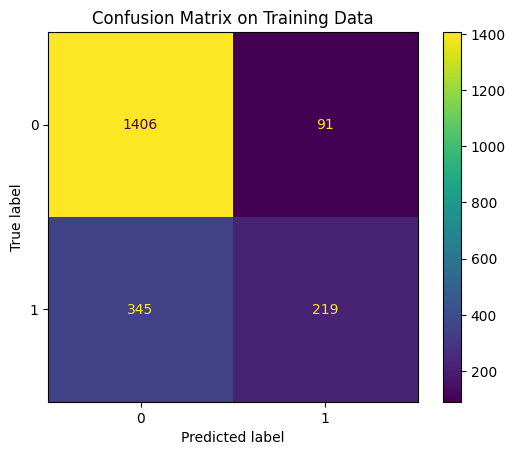

In [75]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix on Training Data')

### 10.Regression
#### 10.1 Train/Test Sets

We can now look at the regression part of this project. We want to predict the total value of a claim, assuming a claim has been made. We start by creating the test/train sets, using only records where the claim value > 0.

In [76]:
# Filter to only rows with a non-zero claim value
claim_data = data_df[data_df['new_claim_value'] > 0]

# Create clean copy of training data
X_reg = claim_data.copy()
y_reg = claim_data['new_claim_value']

# Drop the target feature
X_reg.drop(columns=['new_claim_value','is_claim', 'claim_value_cat'], inplace=True)

# Create train/test split
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

We can now use the pipeline to preprocess our train set.

In [77]:
# Use the same pipeline as the classifier model to preprocess X train
X_reg_train_prepared = preprocess_pipeline.fit_transform(X_reg_train)

#### 10.2. Model Selection
We'll start by looking at the performance of some of the most popular regression models.

In [78]:
regs = [
    ('Linear Regression', LinearRegression()),
    ('Logistic Regression', LogisticRegression(random_state=42, max_iter=25, solver='sag', tol=3)),
    ('SGD Regressor', SGDRegressor(random_state=42)),
    ('Decision Tree Regression ', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('KNN Model ', KNeighborsRegressor()),
    ('Support Vector Machines (SVM)', SVR(gamma=2, C=1)),
    ('XGBRegressor', XGBRegressor(random_state=42))
]

Like with the classification models, we'll use a KFold object to use the same folds for the cross-validation of each model.

For the scoring of the model, we'll use the RMSE as it's more sensitive to outliers.

In [79]:
# Create KFold object with 10 folds
reg_kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dictionary to store results
reg_results = {}

# Evaluate each classifier using cross-validation
for reg_name, reg in regs:
    cv_rmses = -cross_val_score(reg, X_reg_train_prepared, y_reg_train, cv=reg_kf, scoring='neg_root_mean_squared_error')
    reg_results[reg_name] = cv_rmses

reg_cv_scores_df = pd.DataFrame(reg_results)

And again, let's create a boxplot of the results of the cross-validation for each model.

Text(0.5, 1.0, 'Cross-Validation Scores for Different Regressors')

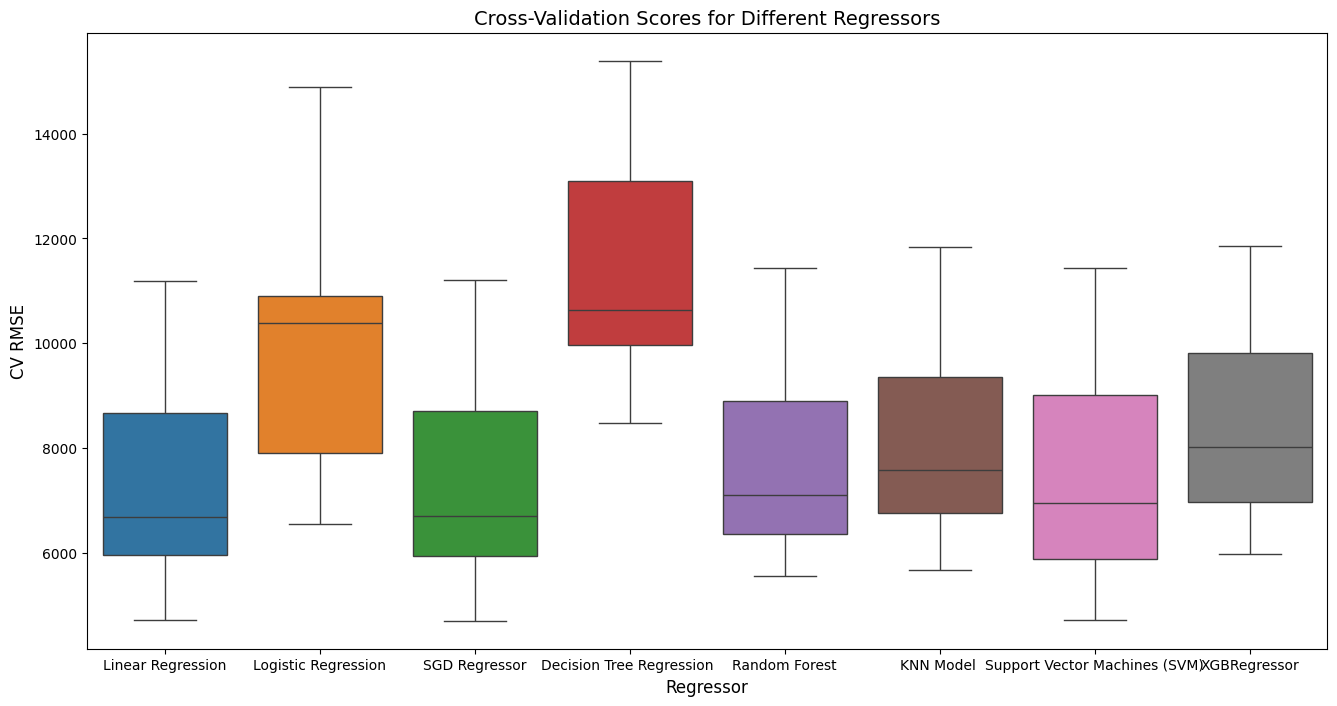

In [80]:
# Plot scores
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(reg_cv_scores_df)

# Add axis labels
ax.set_xlabel('Regressor', fontsize=12)
ax.set_ylabel('CV RMSE', fontsize=12)
ax.set_title('Cross-Validation Scores for Different Regressors', fontsize=14)

As we're using the RMSE as the scoring method, lower is better. We can see the linear regression and SGD Regressor models performed the best. Their scores were very similar, as the models themselves are. As we have more flexibility to tune the SGD Regressor, we'll proceed with that.

#### 10.3. Hyperparameter Optimisation
As we did with the classification model, we'll first use random search to cover a large parameter space.

In [90]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import numpy as np

# Parameter grid
reg_param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'invscaling'],
    'eta0': uniform(0.001, 0.1),
    'max_iter': randint(100, 1000),
    'tol': uniform(1e-6, 1e-3)
}

# Regressor
sgd_regressor = SGDRegressor(random_state=42)

# Randomized Search (✅ correct CV for regression)
reg_random_search = RandomizedSearchCV(
    estimator=sgd_regressor,
    param_distributions=reg_param_grid,
    n_iter=500,
    scoring='neg_root_mean_squared_error',  # ✅ better
    cv=reg_kf,
    verbose=1,
    random_state=42,
    n_jobs=-1
)




In [96]:
# Fit the model using RandomizedSearchCV
reg_random_search.fit(X_reg_train_prepared, y_reg_train)

# Best RMSE score
best_rmse = -reg_random_search.best_score_

# Print results
print("Best parameters found:", reg_random_search.best_params_)
print("Best cross-validation RMSE:", best_rmse)


Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Best parameters found: {'alpha': 0.008548753109694546, 'eta0': 0.003327193573582587, 'learning_rate': 'invscaling', 'max_iter': 214, 'penalty': 'l2', 'tol': 0.0004970374542934063}
Best cross-validation RMSE: 57859482.79240942


We can now use grid search with the reduce parameter space.

In [97]:
# Define the parameter grid for SGDRegressor
reg_param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'invscaling'],
    'eta0': uniform(0.001, 0.1),
    'max_iter': randint(100, 1000),
    'tol': uniform(1e-6, 1e-3)
}

# Initialise the regressor
sgd_regressor = SGDRegressor(random_state=42)

# Create random search
reg_random_search = RandomizedSearchCV(
    estimator=sgd_regressor,
    param_distributions=reg_param_grid,
    n_iter=500,
    scoring='neg_mean_squared_error',
    cv=reg_kf,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

Let's now fit the grid search, and return the best parameter values and best score.

In [99]:
# Fit the model using RandomizedSearchCV
reg_random_search.fit(X_reg_train_prepared, y_reg_train)

# Convert MSE to RMSE
score = np.sqrt(-reg_random_search.best_score_)

# Print the best parameters and the best score
print("Best parameters found:", reg_random_search.best_params_)
print("Best cross-validation RMSE:", score)


Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Best parameters found: {'alpha': 0.008548753109694546, 'eta0': 0.003327193573582587, 'learning_rate': 'invscaling', 'max_iter': 214, 'penalty': 'l2', 'tol': 0.0004970374542934063}
Best cross-validation RMSE: 7606.542104820654


We've only managed to improve the model score very slightly, but an improvement nonetheless.

#### 10.4. Model Evaluation
We can now test our regression model with the test sets to see our final score.

In [101]:
# Transform test data (NO fitting on test set)
X_reg_test_prepared = preprocess_pipeline.transform(X_reg_test)

# Predict using best model from RandomizedSearchCV
y_reg_pred = reg_random_search.best_estimator_.predict(X_reg_test_prepared)

# Evaluation metrics
mse = mean_squared_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_reg_test, y_reg_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


RMSE: 8381.562608294182
MAE: 3555.5655342331675


We can see the RMSE score was slightly higher than what we saw in the train sets, but still fairly inline. As with the classification model, there is still lots of room for potential improvement, like additional feature engineering, investigating feature importance or combining multiple models to create an ensemble.